###  CONTENT BASED IMAGE RETRIEVAL

In [1]:
import cv2 as cv
import numpy as np
import scipy
import pickle
import random
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.decomposition import LatentDirichletAllocation
from scipy.spatial.distance import euclidean,cosine
import matplotlib.image as mpimg
import joblib
star = cv.xfeatures2d.SURF_create()
sift = sift = cv.xfeatures2d.SIFT_create()

In [2]:
directory='./mydataset'
img_dirs=['hawksbill','airplanes','watch','brain','stop_sign','sunflower']

In [ ]:
img_dirs

### Finding the key points and feature descriptors using SIFT

In [ ]:
desc=[]

X=[]

final_images=[]

for img_dir in img_dirs:
    
    images = os.listdir(directory+'/'+img_dir)
    
    for img_name in images:
        
        img_path=os.path.join(directory,img_dir,img_name)
        
        img=cv.imread(img_path)
        
        kps=star.detect(img)
        
        kp1, des1 = sift.compute(img, kps)
        
        try :
            
            if (des1.all!=None):
                
                final_images.append(img_path)
                
                desc.append([])
                
                desc[-1].append(des1)
                
                for d in des1:
                    
                    X.append(d)
        except:
            
            pass


In [ ]:
output = open('descriptor.pkl', 'wb')
pickle.dump(desc,output,pickle.HIGHEST_PROTOCOL) 


In [ ]:
out = open('images.pkl', 'wb')
pickle.dump(final_images,out,pickle.HIGHEST_PROTOCOL)

In [ ]:
 def image_resize(image, width = None, height = None, inter = cv.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

### Clustering of key points to make dictionary using k means

In [ ]:
dictionary_size=500
kmeans = MiniBatchKMeans(init='k-means++',n_clusters=dictionary_size,batch_size=500,random_state=0).fit(X)
centers=kmeans.cluster_centers_
print("clustered")

In [ ]:
cen = open('clustered_2000.pkl', 'wb')
pickle.dump(centers,cen,pickle.HIGHEST_PROTOCOL)

### Flann matcher to match key points to words in dictionary

In [ ]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50) 

flann = cv.FlannBasedMatcher(index_params,search_params)
arr=[]
for i in range(len(desc)):
    matches = flann.knnMatch(np.asarray(desc[i][0],np.float32),np.asarray(centers,np.float32),k=1)
    
    arr.append([matches[j][0].trainIdx for j in range(len(matches))])


In [ ]:
len(X)

### Creating a histogram of visual words

In [ ]:
doc_word=[]
for i in range(len(arr)):
    hist=[0]*dictionary_size
    c={}
    for j in range(len(arr[i])):
        if (arr[i][j] in c):
            c[arr[i][j]]+=1
        else:
            c[arr[i][j]]=1
    for k in c:
        hist[k]=c[k]
    doc_word.append(hist)
print("histogram with frequency of words in an image done")       
    

In [ ]:
his = open('histogram.pkl', 'wb')
pickle.dump(doc_word,his,pickle.HIGHEST_PROTOCOL)

### Topic Modelling using Latent Dirichlet Allocation Method 

In [ ]:
ld = LatentDirichletAllocation(n_components=10,learning_method='online',max_iter=100)
ld.fit(doc_word)
topic_dist=ld.transform(doc_word)


In [ ]:
joblib.dump(ld, 'lda_model.jl')


In [ ]:
# commented thing for previous pickle 
'''t_dist = open('topic_dist.pkl', 'wb')
pickle.dump(topic_dist,t_dist,pickle.HIGHEST_PROTOCOL)''' 
joblib.dump(topic_dist, 'topic_dist.jl')

In [ ]:
topic_dist[0]


In [ ]:
def chisquare(a,b):
    s = a+b
    d = (a-b)**2
    q = 0.5*np.sum(d/s)
    return q

### Loading of models 

In [3]:
o = open('images.pkl', 'rb')
final_images = pickle.load(o)
cen = open('clustered_2000.pkl', 'rb')
centers = pickle.load(cen)

# commented thing for previous pickle 
#t_distribution = open('topic_dist.pkl', 'rb')
#topic_dist = pickle.load(t_distribution)

topic_dist = joblib.load('topic_dist.jl')

lda = joblib.load('lda_model.jl')



In [ ]:
random.seed(1)
count = 0
precision=0
for img_category in img_dirs:
    l = os.listdir(os.path.join(directory,img_category))
    random.shuffle(l)
    for i in l[:5]:
#img_category = 'airplanes'
#query_image_path=directory+'/'+ img_category+'/image_0020.jpg'
        query_image_path=os.path.join(directory,img_category,i)
        query_img=cv.imread(query_image_path)
        if (type(query_img)!=type(None)):
            
            query_img_kps=star.detect(query_img,None)

            query_kp, query_des = sift.compute(query_img,query_img_kps)



            FLANN_INDEX_KDTREE = 0
            index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
            search_params = dict(checks=50) 

            flann = cv.FlannBasedMatcher(index_params,search_params)
            query_arr=[]
            matches = flann.knnMatch(np.asarray(query_des,np.float32),np.asarray(centers,np.float32),k=1)
            query_arr.append([matches[j][0].trainIdx for j in range(len(matches))])

            dictionary_size=500
            q={}
            query_hist=[0]*dictionary_size
            for j in range(len(query_arr[0])):
                if (query_arr[0][j] in q):
                    q[query_arr[0][j]]+=1
                else:
                    q[query_arr[0][j]]=1
            for k in q:
                query_hist[k]=q[k]

            query_hist=np.array(query_hist).reshape(1,-1)

            query_topic = ld.transform(query_hist)

            euc=[]
            for i in range(len(topic_dist)):
                euc.append([final_images[i],cosine(query_topic[0],topic_dist[i])])

            img_sorted = sorted(euc, key=lambda x: x[1])
            precision+= wprecision(img_category,img_sorted)
            count+=1
print(precision/count)

### Querying images 

In [6]:
#['stop_sign','sunflower','airplanes','brain','hawksbill','watch']

img_category = 'test'
query_image_path=directory+'/'+ img_category+'/test5.jpeg'
query_img=cv.imread(query_image_path)
if (type(query_img)!=type(None)):

    query_img_kps=star.detect(query_img)

    query_kp, query_des = sift.compute(query_img,query_img_kps)

    

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50) 

    flann = cv.FlannBasedMatcher(index_params,search_params)
    query_arr=[]
    matches = flann.knnMatch(np.asarray(query_des,np.float32),np.asarray(centers,np.float32),k=1)
    query_arr.append([matches[j][0].trainIdx for j in range(len(matches))])

    dictionary_size=500
    q={}
    query_hist=[0]*dictionary_size
    for j in range(len(query_arr[0])):
        if (query_arr[0][j] in q):
            q[query_arr[0][j]]+=1
        else:
            q[query_arr[0][j]]=1
    for k in q:
        query_hist[k]=q[k]

    query_hist=np.array(query_hist).reshape(1,-1)

    query_topic = lda.transform(query_hist)

    euc=[]
    for i in range(len(topic_dist)):
        euc.append([final_images[i],cosine(query_topic[0],topic_dist[i])])

    img_sorted = sorted(euc, key=lambda x: x[1])


In [ ]:
img_sorted

In [ ]:
def wprecision(img_type,img_sorted):
    a = 0
    b = 0
    for q in range(1,22):
        if (img_sorted[q][0].split('/')[2]==img_type): # if relevant 
            a += (1/q)*1
        b+=(1/q)
    return a/b


In [ ]:
# weighted precision 
precision = wprecision(img_category,img_sorted)
print(precision)

### Displaying the Queried images 

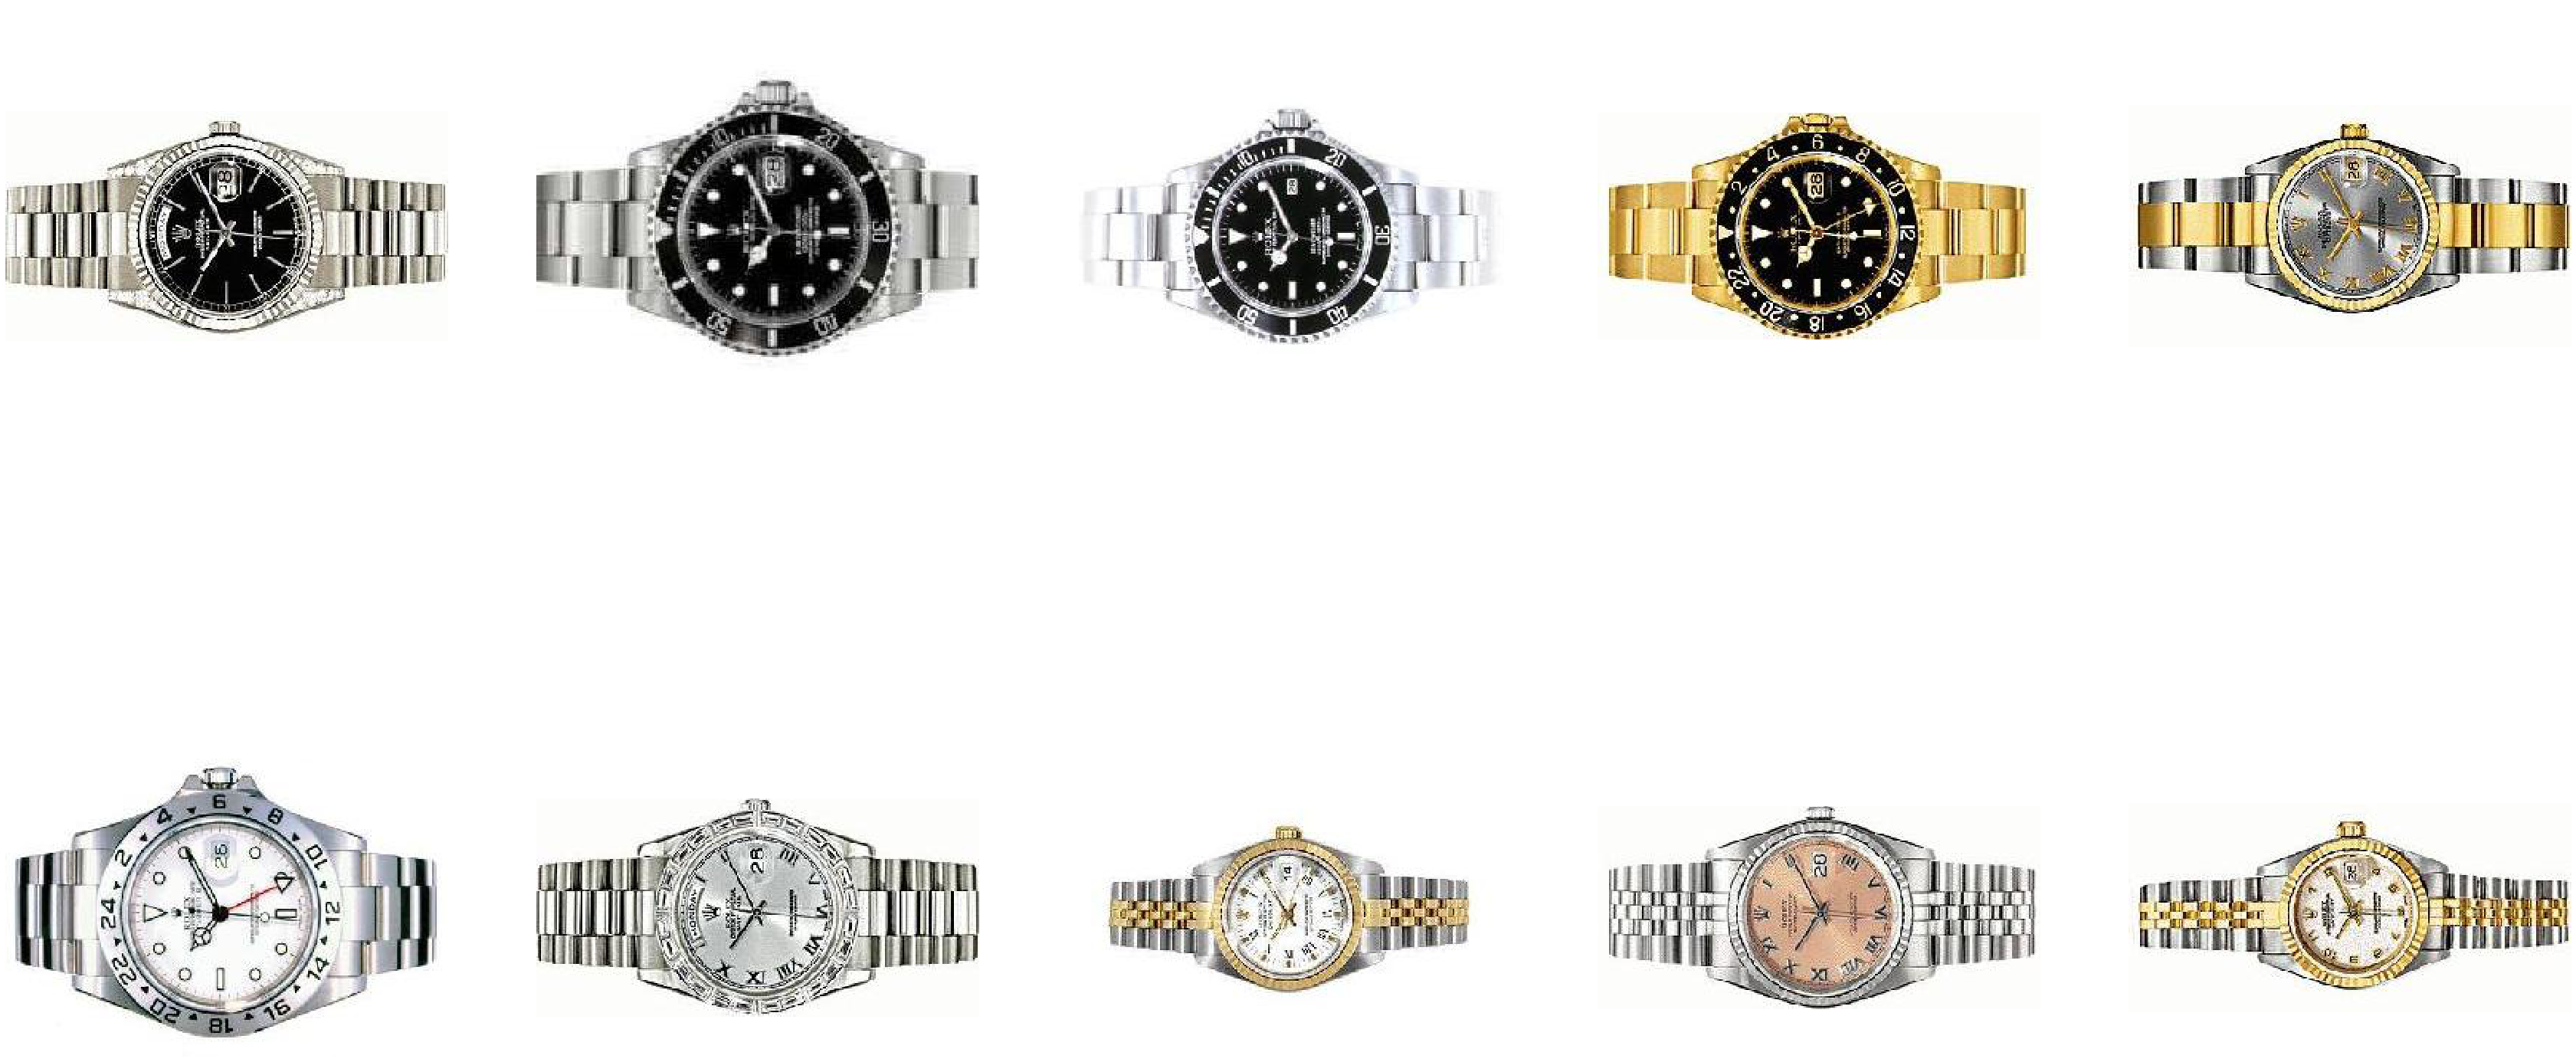

In [7]:
rows = 2    
columns = 5
f, axarr = plt.subplots(rows,columns,figsize=(60,30))
i = 0
j = 0

images = []
for img_path,temp in img_sorted[:10]:
    images.append(mpimg.imread(img_path))

for image in images:
    axarr[i,j].imshow(image)
    axarr[i,j].axis('off')
    j+=1
    if(j%columns == 0):
        i+=1
        j = 0


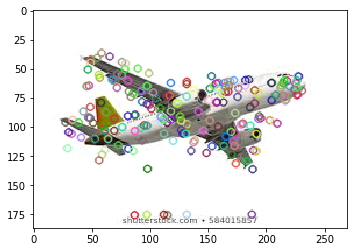

In [16]:
img_category = 'test'
query_image_path=directory+'/'+ img_category+'/test2.jpeg'
query_img=cv.imread(query_image_path)
query_img_kps=star.detect(query_img)
p = cv.drawKeypoints(query_img,query_img_kps,outImage=None)
plt.imshow(p)

